# Simulating orbital dynamics with an HNN
Sam Greydanus

In [1]:
import torch, time, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = './experiment-orbits'
sys.path.append(EXPERIMENT_DIR)

from nn_models import MLP
from hnn import HNN
from utils import L2_loss, to_pickle, from_pickle
from data import get_dataset, sample_orbits, coords2state
from data import potential_energy, kinetic_energy, total_energy

## Set some notebook constants

In [4]:
DPI = 120
FORMAT = 'png'

def get_args():
    return {'input_dim': 2*4, # two bodies, each with q_x, q_y, p_z, p_y
         'hidden_dim': 200,
         'learn_rate': 1e-3,
         'input_noise': 0.,
         'batch_size': 200,
         'nonlinearity': 'tanh',
         'total_steps': 1500,
         'field_type': 'solenoidal',
         'print_every': 200,
         'verbose': True,
         'name': '2body',
         'seed': 0,
         'save_dir': '{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Make a model of $N$-body interaction
Basically, we are using Newton's law to get accelerations. Then we pass the velocities and accelerations to the ODE solver, which uses them to update the positions and velocities (respectively) of the bodies.
$$
m_i a_i = G m_i \sum_{j\neq i}^N \frac{r_j-r_i}{||r_j-r_i||^3}
$$

In [3]:
# ##### ENERGY #####
# def potential_energy(state):
#     '''U=\sum_i,j>i G m_i m_j / r_ij'''
#     tot_energy = np.zeros((1,1,state.shape[2]))
#     for i in range(state.shape[0]):
#         for j in range(i+1,state.shape[0]):
#             r_ij = ((state[i:i+1,1:3] - state[j:j+1,1:3])**2).sum(1, keepdims=True)**.5
#             m_i = state[i:i+1,0:1]
#             m_j = state[j:j+1,0:1]
#     tot_energy += m_i * m_j / r_ij
#     U = -tot_energy.sum(0).squeeze()
#     return U

# def kinetic_energy(state):
#     '''T=\sum_i .5*m*v^2'''
#     energies = .5 * state[:,0:1] * (state[:,3:5]**2).sum(1, keepdims=True)
#     T = energies.sum(0).squeeze()
#     return T

# def total_energy(state):
#     return potential_energy(state) + kinetic_energy(state)


# ##### DYNAMICS #####
# def get_accelerations(state, epsilon=0):
#     # shape of state is [bodies x properties]
#     net_accs = [] # [nbodies x 2]
#     for i in range(state.shape[0]): # number of bodies
#         other_bodies = np.concatenate([state[:i, :], state[i+1:, :]], axis=0)
#         displacements = other_bodies[:, 1:3] - state[i, 1:3] # indexes 1:3 -> pxs, pys
#         distances = (displacements**2).sum(1, keepdims=True)**0.5
#         masses = other_bodies[:, 0:1] # index 0 -> mass
#         pointwise_accs = masses * displacements / (distances**3 + epsilon) # G=1
#         net_acc = pointwise_accs.sum(0, keepdims=True)
#         net_accs.append(net_acc)
#     net_accs = np.concatenate(net_accs, axis=0)
#     return net_accs
  
# def update(t, state):
#     state = state.reshape(-1,5) # [bodies, properties]
#     deriv = np.zeros_like(state)
#     deriv[:,1:3] = state[:,3:5] # dx, dy = vx, vy
#     deriv[:,3:5] = get_accelerations(state)
#     return deriv.reshape(-1)

## Integration settings

In [4]:
# def get_orbit(state, update_fn=update, t_points=100, t_span=[0,2], **kwargs):
#     if not 'rtol' in kwargs.keys():
#         kwargs['rtol'] = 1e-9

#     orbit_settings = locals()

#     nbodies = state.shape[0]
#     t_eval = np.linspace(t_span[0], t_span[1], t_points)
#     orbit_settings['t_eval'] = t_eval

#     path = solve_ivp(fun=update_fn, t_span=t_span, y0=state.flatten(),
#                      t_eval=t_eval, **kwargs)
#     orbit = path['y'].reshape(nbodies, 5, t_points)
#     return orbit, orbit_settings

## Make a dataset of near-circular orbits

In [5]:
# def random_config(orbit_noise=5e-2, min_radius=0.5, max_radius=1.5):
#     state = np.zeros((2,5))
#     state[:,0] = 1
#     pos = np.random.rand(2) * (max_radius-min_radius) + min_radius
#     r = np.sqrt( np.sum((pos**2)) )

#     # velocity that yields a circular orbit
#     vel = np.flipud(pos) / (2 * r**1.5)
#     vel[0] *= -1
#     vel *= 1 + orbit_noise*np.random.randn()

#     # make the circular orbits SLIGHTLY elliptical
#     state[:,1:3] = pos
#     state[:,3:5] = vel
#     state[1,1:] *= -1
#     return state

# def sample_orbits(timesteps=50, trials=200, nbodies=2, orbit_noise=5e-2,
#                   min_radius=0.5, max_radius=1.5, t_span=[0, 20], verbose=False, **kwargs):
    
#     orbit_settings = locals()
#     if verbose:
#         print("Making a dataset of near-circular 2-body orbits:")
    
#     x, dx, e = [], [], []
#     N = timesteps*trials
#     while len(x) < N:

#         state = random_config(orbit_noise, min_radius, max_radius)
#         orbit, settings = get_orbit(state, t_points=timesteps, t_span=t_span, **kwargs)
#         batch = orbit.transpose(2,0,1).reshape(-1,10)

#         for state in batch:
#             dstate = update(None, state)
            
#             # reshape from [nbodies, state] where state=[m, qx, qy, px, py]
#             # to [canonical_coords] = [qx1, qx2, qy1, qy2, px1,px2,....]
#             coords = state.reshape(nbodies,5).T[1:].flatten()
#             dcoords = dstate.reshape(nbodies,5).T[1:].flatten()
#             x.append(coords)
#             dx.append(dcoords)

#             shaped_state = state.copy().reshape(2,5,1)
#             e.append(total_energy(shaped_state))

#     data = {'coords': np.stack(x)[:N],
#             'dcoords': np.stack(dx)[:N],
#             'energy': np.stack(e)[:N] }
#     return data, orbit_settings


# def make_orbits_dataset(test_split=0.2, **kwargs):
#     data, orbit_settings = sample_orbits(**kwargs)
    
#     # make a train/test split
#     split_ix = int(data['coords'].shape[0] * test_split)
#     split_data = {}
#     for k, v in data.items():
#         split_data[k], split_data['test_' + k] = v[split_ix:], v[:split_ix]
#     data = split_data

#     data['meta'] = orbit_settings
#     return data

# def get_dataset(experiment_name, save_dir, **kwargs):
#     '''Returns an orbital dataset. Also constructs
#     the dataset if no saved version is available.'''

#     path = '{}/{}-orbit-dataset.pkl'.format(save_dir, experiment_name)

#     try:
#         data = from_pickle(path)
#         print("Successfully loaded data from {}".format(path))
#     except:
#         print("Had a problem loading data from {}. Rebuilding dataset...".format(path))
#         data = make_orbits_dataset(**kwargs)
#         to_pickle(data, path)

#     return data

## Visualize one random config

In [7]:
# def coords2state(coords, nbodies=2, mass=1):
#     timesteps = coords.shape[0]
#     state = coords.T
#     state = state.reshape(-1, nbodies, timesteps).transpose(1,0,2)
#     mass_vec = mass * np.ones((nbodies, 1, timesteps))
#     state = np.concatenate([mass_vec, state], axis=1)
#     return state

Making a dataset of near-circular 2-body orbits:


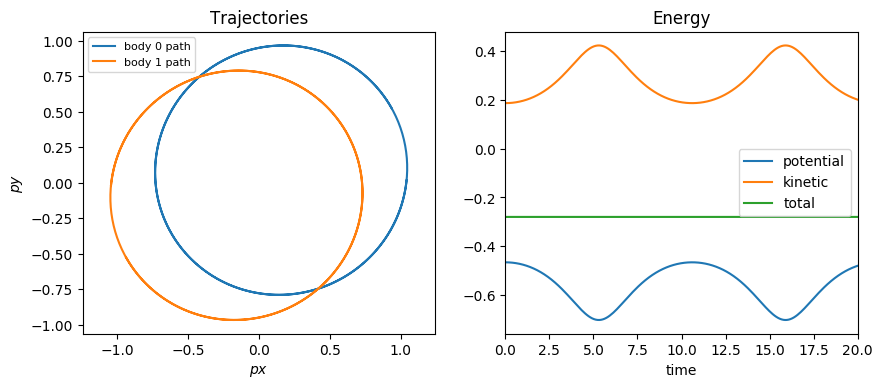

In [3]:
np.random.seed(2)

timesteps = 200
t_span = [0,20]
data, settings = sample_orbits(timesteps=timesteps, t_span=t_span, trials=1, verbose=True)
orbit = coords2state(data['coords'])

# draw trajectories
fig = plt.figure(figsize=[10,4], dpi=100)
plt.subplot(1,2,1)
plt.title('Trajectories')
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], label='body {} path'.format(i))

plt.axis('equal')
plt.xlabel('$px$') ; plt.ylabel('$py$')
plt.legend(fontsize=8)

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
t_range = np.linspace(t_span[0], t_span[1], timesteps)
plt.plot(t_range, potential_energy(orbit), label='potential')
plt.plot(t_range, kinetic_energy(orbit), label='kinetic')
plt.plot(t_range, total_energy(orbit), label='total')
plt.legend()
plt.xlim(*settings['t_span'])

plt.show()

In [5]:
arg_dict = get_args()
arg_dict['baseline'] = True
args = ObjectView(arg_dict)

data = get_dataset(args.name, args.save_dir)

Successfully loaded data from ./experiment-orbits/2body-orbit-dataset.pkl


## Train model

In [12]:
# def train(args):
#     # set random seed
#     torch.manual_seed(args.seed)
#     np.random.seed(args.seed)

#     # init model and optimizer
#     if args.verbose:
#         print("Training baseline model:" if args.baseline else "Training HNN model:")

#     output_dim = args.input_dim if args.baseline else 2
#     nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
#     model = HNN(args.input_dim, differentiable_model=nn_model,
#               field_type=args.field_type, baseline=args.baseline)
#     optim = torch.optim.Adam(model.parameters(), args.learn_rate, weight_decay=0)

#     # arrange data
#     data = get_dataset(args.name, args.save_dir, verbose=True)
#     x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
#     test_x = torch.tensor( data['test_coords'], requires_grad=True, dtype=torch.float32)
#     dxdt = torch.Tensor(data['dcoords'])
#     test_dxdt = torch.Tensor(data['test_dcoords'])

#     # vanilla train loop
#     stats = {'train_loss': [], 'test_loss': []}
#     for step in range(args.total_steps+1):

#         # train step
#         dxdt_hat = model.time_derivative(x)
#         dxdt_hat += args.input_noise * torch.randn(*x.shape) # add noise, maybe
#         loss = L2_loss(dxdt, dxdt_hat)
#         loss.backward()
#         grad = torch.cat([p.grad.flatten() for p in model.parameters()]).clone()
#         optim.step() ; optim.zero_grad()

#         # run test data
#         test_dxdt_hat = model.time_derivative(test_x)
#         test_dxdt_hat += args.input_noise * torch.randn(*test_x.shape) # add noise, maybe
#         test_loss = L2_loss(test_dxdt, test_dxdt_hat)

#         # logging
#         stats['train_loss'].append(loss.item())
#         stats['test_loss'].append(test_loss.item())
#         if args.verbose and step % args.print_every == 0:
#             print("step {}, train_loss {:.4e}, test_loss {:.4e}, grad norm {:.4e}, grad std {:.4e}"
#                   .format(step, loss.item(), test_loss.item(), grad@grad, grad.std()))

#     return model, stats

In [13]:
arg_dict = get_args()
arg_dict['baseline'] = True
args = ObjectView(arg_dict)

base_model, base_stats = train(args)

Training baseline model:
Successfully loaded data from ./experiment-orbits/2body-orbit-dataset.pkl
step 0, train_loss 6.8331e-02, test_loss 1.8858e-02, grad norm 3.4241e-01, grad std 2.8021e-03
step 200, train_loss 3.3722e-04, test_loss 1.8477e-04, grad norm 4.2715e-08, grad std 9.8972e-07
step 400, train_loss 3.1497e-04, test_loss 1.7607e-04, grad norm 2.0596e-08, grad std 6.8724e-07
step 600, train_loss 2.9233e-04, test_loss 1.6913e-04, grad norm 1.7067e-08, grad std 6.2560e-07
step 800, train_loss 2.6550e-04, test_loss 1.6097e-04, grad norm 5.7108e-08, grad std 1.1444e-06
step 1000, train_loss 2.3355e-04, test_loss 1.4961e-04, grad norm 2.1235e-08, grad std 6.9783e-07
step 1200, train_loss 2.7021e-04, test_loss 2.0286e-04, grad norm 5.7059e-04, grad std 1.1439e-04
step 1400, train_loss 1.7123e-04, test_loss 1.1871e-04, grad norm 1.1803e-05, grad std 1.6452e-05


## Qualitative results